In [2]:
from IPython.display import clear_output
!pip install tf_explain
clear_output()

In [3]:

import os
import keras
import numpy as np
import pandas as pd
from glob import glob
import tensorflow as tf
import tensorflow.image as tfi


from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.utils import to_categorical



import matplotlib.pyplot as plt

# Model 
from keras.models import Model
from keras.layers import Layer
from keras.layers import Conv2D
from keras.layers import Dropout
from keras.layers import UpSampling2D
from keras.layers import concatenate
from keras.layers import Add
from keras.layers import Multiply
from keras.layers import Input
from keras.layers import MaxPool2D
from keras.layers import BatchNormalization

# Callbacks 
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from tf_explain.core.grad_cam import GradCAM

# Metrics
from keras.metrics import MeanIoU

In [4]:
def load_image(image, SIZE):
    return np.round(tfi.resize(img_to_array(load_img(image))/255.,(SIZE, SIZE)),4)

def load_images(image_paths, SIZE, mask=False, trim=None):
    if trim is not None:
        image_paths = image_paths[:trim]
    
    if mask:
        images = np.zeros(shape=(len(image_paths), SIZE, SIZE, 1))
    else:
        images = np.zeros(shape=(len(image_paths), SIZE, SIZE, 3))
    
    for i,image in enumerate(image_paths):
        img = load_image(image,SIZE)
        if mask:
            images[i] = img[:,:,:1]
        else:
            images[i] = img
    
    return images

In [5]:
def show_image(image, title=None, cmap=None, alpha=1):
    plt.imshow(image, cmap=cmap, alpha=alpha)
    if title is not None:
        plt.title(title)
    plt.axis('off')

def show_mask(image, mask, cmap=None, alpha=0.4):
    plt.imshow(image)
    plt.imshow(tf.squeeze(mask), cmap=cmap, alpha=alpha)
    plt.axis('off')

In [6]:
SIZE = 256

In [7]:
root_path = r"D:\TRAITEMENT_IMAGE\PROJET_419\Dataset_BUSI_with_GT"
classes = sorted(os.listdir(root_path))
classes

['benign', 'dilated_masks', 'malignant', 'normal']

In [8]:
from glob import glob
import os

root_path = r"D:\TRAITEMENT_IMAGE\PROJET_419\Dataset_BUSI_with_GT"
classes = sorted([d for d in os.listdir(root_path) if os.path.isdir(os.path.join(root_path, d))])

#  chemins
single_mask_paths = [sorted(glob(os.path.join(root_path, name, "*mask.png"))) for name in classes]
double_mask_paths = [sorted(glob(os.path.join(root_path, name, "*mask_1.png"))) for name in classes]

# Vérifiction
print(f"Nombre total de masques simples trouvés: {sum(len(paths) for paths in single_mask_paths)}")
print(f"Nombre total de masques doubles trouvés: {sum(len(paths) for paths in double_mask_paths)}")


Nombre total de masques simples trouvés: 780
Nombre total de masques doubles trouvés: 0


In [9]:
from glob import glob
import os


root_path = r"D:\TRAITEMENT_IMAGE\PROJET_419\Dataset_BUSI_with_GT"

# Identifier les sous-dossiers valides (classes)
classes = sorted([d for d in os.listdir(root_path) if os.path.isdir(os.path.join(root_path, d))])

# Initialisation des compteurs
total_images = 0
total_single_masks = 0
total_double_masks = 0

# Parcours des classes pour compter les images et masques
for name in classes:
    image_files = glob(os.path.join(root_path, name, "*.png"))
    single_masks = glob(os.path.join(root_path, name, "*mask.png"))
    double_masks = glob(os.path.join(root_path, name, "*mask_1.png"))
    
  
    
    total_images += len(image_files)
    total_single_masks += len(single_masks)
    total_double_masks += len(double_masks)

# Résumé global
print("Résumé global :")
print(f"  Total d'images : {total_images}")
print(f"  Total de masques simples : {total_single_masks}")
print(f"  Total de masques doubles : {total_double_masks}")


Résumé global :
  Total d'images : 1561
  Total de masques simples : 780
  Total de masques doubles : 0


In [10]:
import os
from glob import glob


root_path = r"D:\TRAITEMENT_IMAGE\PROJET_419\Dataset_BUSI_with_GT"

# Supprimer tous les fichiers *mask_1.png dans chaque classe
deleted_files = 0
for class_folder in os.listdir(root_path):
    class_path = os.path.join(root_path, class_folder)
    if os.path.isdir(class_path):
        mask_1_files = glob(os.path.join(class_path, "*mask_1.png"))
        for file in mask_1_files:
            os.remove(file)
            deleted_files += 1

print(f"{deleted_files} fichiers *mask_1.png ont été supprimés.")


0 fichiers *mask_1.png ont été supprimés.


In [11]:
image_paths = []
mask_paths = []
for class_path in single_mask_paths:
    for path in class_path:
        img_path = path.replace('_mask','')
        image_paths.append(img_path)
        mask_paths.append(path)
print(f"single_mask_paths contient {len(single_mask_paths)} sous-listes.")
for i, class_path in enumerate(single_mask_paths):
    print(f"Sous-liste {i}: contient {len(class_path)} masques.")


single_mask_paths contient 4 sous-listes.
Sous-liste 0: contient 437 masques.
Sous-liste 1: contient 0 masques.
Sous-liste 2: contient 210 masques.
Sous-liste 3: contient 133 masques.


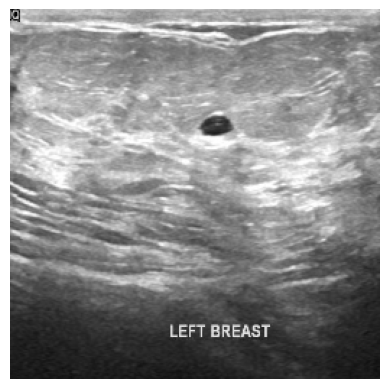

In [12]:
show_image(load_image(image_paths[0], SIZE))

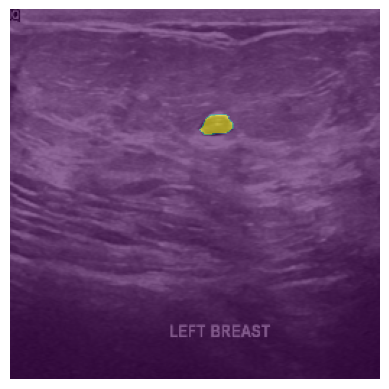

In [13]:
show_mask(load_image(image_paths[0], SIZE), load_image(mask_paths[0], SIZE)[:,:,0], alpha=0.6)

In [14]:
#show_image(load_image('../input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (100).png', SIZE))

In [15]:
images = load_images(image_paths, SIZE)
masks = load_images(mask_paths, SIZE, mask=True)

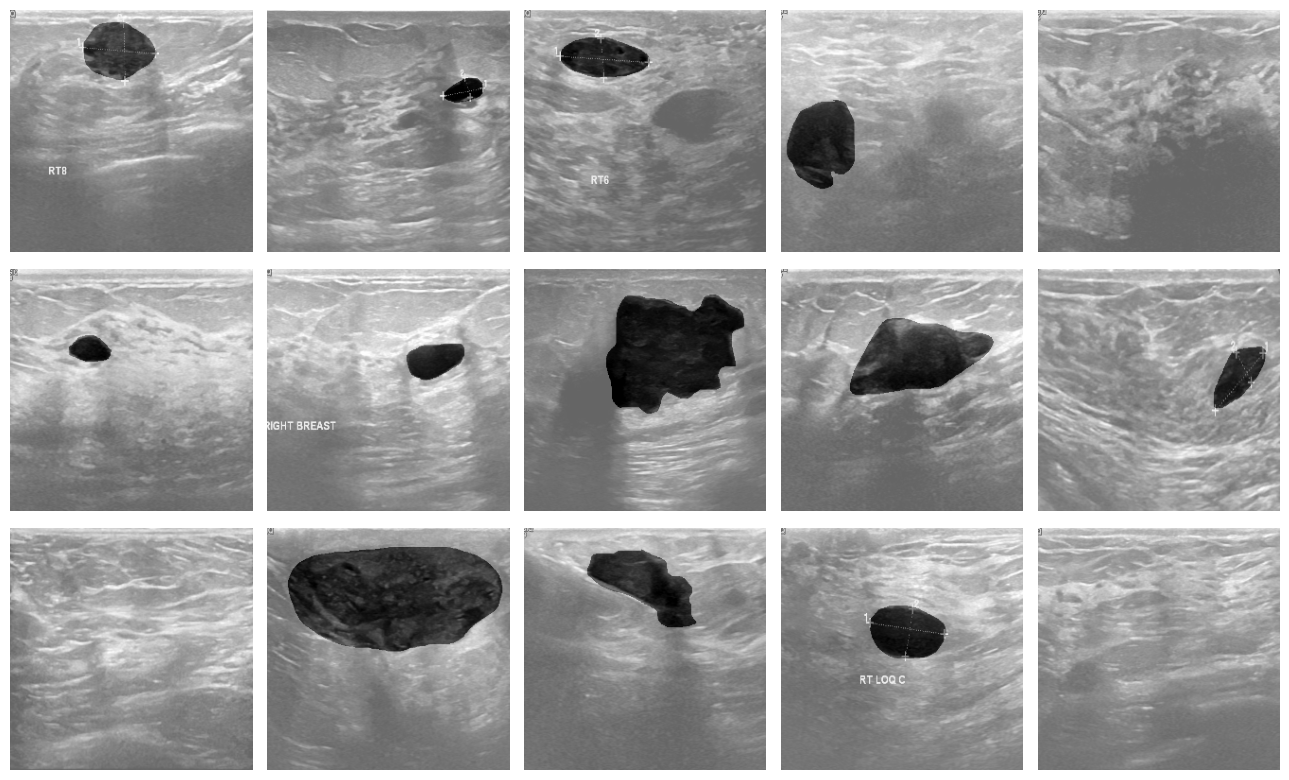

In [16]:
plt.figure(figsize=(13,8))
for i in range(15):
    plt.subplot(3,5,i+1)
    id = np.random.randint(len(images))
    show_mask(images[id], masks[id], cmap='binary')
plt.tight_layout()
plt.show()

In [17]:
class EncoderBlock(Layer):

    def __init__(self, filters, rate, pooling=True, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)

        self.filters = filters
        self.rate = rate
        self.pooling = pooling

        self.c1 = Conv2D(filters, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')
        self.drop = Dropout(rate)
        self.c2 = Conv2D(filters, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')
        self.pool = MaxPool2D()
    def call(self, X):
        x = self.c1(X)
        x = self.drop(x)
        x = self.c2(x)
        if self.pooling:
            y = self.pool(x)
            return y, x
        else:
            return x

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            'rate':self.rate,
            'pooling':self.pooling
        }

In [18]:
class DecoderBlock(Layer):

    def __init__(self, filters, rate, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)

        self.filters = filters
        self.rate = rate

        self.up = UpSampling2D()
        self.net = EncoderBlock(filters, rate, pooling=False)

    def call(self, X):
        X, skip_X = X
        x = self.up(X)
        c_ = concatenate([x, skip_X])
        x = self.net(c_)
        return x
    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            'rate':self.rate,
        }

In [19]:
class AttentionGate(Layer):

    def __init__(self, filters, bn, **kwargs):
        super(AttentionGate, self).__init__(**kwargs)

        self.filters = filters
        self.bn = bn

        self.normal = Conv2D(filters, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')
        self.down = Conv2D(filters, kernel_size=3, strides=2, padding='same', activation='relu', kernel_initializer='he_normal')
        self.learn = Conv2D(1, kernel_size=1, padding='same', activation='sigmoid')
        self.resample = UpSampling2D()
        self.BN = BatchNormalization()

    def call(self, X):
        X, skip_X = X
        x = self.normal(X)
        skip = self.down(skip_X)
        x = Add()([x, skip])
        x = self.learn(x)
        x = self.resample(x)
        f = Multiply()([x, skip_X])
        if self.bn:
            return self.BN(f)
        else:
            return f
        # return f

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
           "bn":self.bn
        }

In [20]:
class ShowProgress(Callback):
    def on_epoch_end(self, epochs, logs=None):
        id = np.random.randint(200)
        exp = GradCAM()
        image = images[id]
        mask = masks[id]
        pred_mask = self.model.predict(image[np.newaxis,...])
        cam = exp.explain(
            validation_data=(image[np.newaxis,...], mask),
            class_index=1,
            layer_name='Attention4',
            model=self.model
        )
        plt.figure(figsize=(10,5))

        plt.subplot(1,3,1)
        plt.title("Original Mask")
        show_mask(image, mask, cmap='copper')

        plt.subplot(1,3,2)
        plt.title("Predicted Mask")
        show_mask(image, pred_mask, cmap='copper')

        plt.subplot(1,3,3)
        show_image(cam,title="GradCAM")

        plt.tight_layout()
        plt.show()

In [21]:
# entrées
input_layer = Input(shape=images.shape[-3:])

# Encodeuurr
p1, c1 = EncoderBlock(32,0.1, name="Encoder1")(input_layer)
p2, c2 = EncoderBlock(64,0.1, name="Encoder2")(p1)
p3, c3 = EncoderBlock(128,0.2, name="Encoder3")(p2)
p4, c4 = EncoderBlock(256,0.2, name="Encoder4")(p3)


encoding = EncoderBlock(512,0.3, pooling=False, name="Encoding")(p4)

# Attentiongate  + Decodeur

a1 = AttentionGate(256, bn=True, name="Attention1")([encoding, c4])
d1 = DecoderBlock(256,0.2, name="Decoder1")([encoding, a1])

a2 = AttentionGate(128, bn=True, name="Attention2")([d1, c3])
d2 = DecoderBlock(128,0.2, name="Decoder2")([d1, a2])
a3 = AttentionGate(64, bn=True, name="Attention3")([d2, c2])
d3 = DecoderBlock(64,0.1, name="Decoder3")([d2, a3])


a4 = AttentionGate(32, bn=True, name="Attention4")([d3, c1])
d4 = DecoderBlock(32,0.1, name="Decoder4")([d3, a4])

# sortie 
output_layer = Conv2D(1, kernel_size=1, activation='sigmoid', padding='same')(d4)

# Modelee
model = Model(
    inputs=[input_layer],
    outputs=[output_layer]
)
# Compile
#model.compile(
    #loss='binary_crossentropy',
   # optimizer='adam',
   # metrics=['accuracy', MeanIoU(num_classes=2, name='IoU')])

def dice_loss(y_true, y_pred):
    smooth = 1e-6
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def combined_loss(y_true, y_pred):
    return 0.5 * dice_loss(y_true, y_pred) + 0.5 * tf.keras.losses.binary_crossentropy(y_true, y_pred)


from tensorflow.keras.metrics import MeanIoU

model.compile(
    loss=combined_loss,
    optimizer='adam',
    metrics=['accuracy', MeanIoU(num_classes=2, name='IoU')]
)


optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)  # Réduction du learning rate
#model.compile(optimizer=optimizer, 
#              loss=dice_loss + tf.keras.losses.BinaryCrossentropy(),  
#              metrics=['accuracy', MeanIoU(num_classes=2)])





# Callbacks
cb = [
    # EarlyStopping(patience=3, restore_best_weight=True), # With Segmentation I trust on eyes rather than on metrics
    ModelCheckpoint("AttentionCustomUNet.h5", save_best_only=True),
    ShowProgress()
]

In [25]:
import tensorflow.keras.backend as K

import warnings
# Désactiver les UserWarnings spécifiquement pour keras
warnings.filterwarnings('ignore', category=UserWarning, module='keras')

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Config entrainnemetn
BATCH_SIZE = 8
EPOCHS = 20
SPE = len(images)//BATCH_SIZE

# Utilisation d'un générateur de données pour améliorer l'efficacité de l'entraînement
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalisation des pixels entre 0 et 1
    rotation_range=20,  # Rotation des images entre -20 et 20 degrés
    width_shift_range=0.2,  # Décalage horizontal aléatoire
    height_shift_range=0.2,  # Décalage vertical aléatoire
    shear_range=0.2,  # Cisaillement des images
    zoom_range=0.2,  # Zoom aléatoire
    horizontal_flip=True,  # Flip horizontal aléatoire
    fill_mode='nearest'  # Remplissage des pixels vides après transformation
)

# Appliquer les transformations sur les images et les masques
train_image_generator = train_datagen.flow(images, masks, batch_size=BATCH_SIZE)

# Nombre d'étapes par époque
steps_per_epoch = len(images) // BATCH_SIZE

# Callbacks
checkpoint_cb = ModelCheckpoint('unet_model_best.keras', save_best_only=True)
early_stopping_cb = EarlyStopping(patience=5, restore_best_weights=True)
cb = [checkpoint_cb, early_stopping_cb]

# entrainnement
#model.compile(optimizer='adam', loss=dice_loss, metrics=['accuracy'])
results = model.fit(
    images, masks,
   # train_image_generator,
    validation_split=0.2,
    epochs=EPOCHS,  # Ajuste ce nombre si nécessaire
    steps_per_epoch=SPE,
    #steps_per_epoch=steps_per_epoch,
    #validation_data=train_image_generator,
    #validation_steps=steps_per_epoch,  # Utilise le même nombre d'étapes pour la validation
    batch_size=BATCH_SIZE,
   
    callbacks=cb
)


Epoch 1/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 460s 5s/step - IoU: 0.4544 - accuracy: 0.8978 - loss: 0.5503 - val_IoU: 0.4909 - val_accuracy: 0.9130 - val_loss: 0.6639
Epoch 2/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 456s 5s/step - IoU: 0.4563 - accuracy: 0.9040 - loss: 0.4608 - val_IoU: 0.4909 - val_accuracy: 0.9417 - val_loss: 0.6196
Epoch 3/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 507s 5s/step - IoU: 0.4523 - accuracy: 0.9053 - loss: 0.4282 - val_IoU: 0.4909 - val_accuracy: 0.9813 - val_loss: 0.5480
Epoch 4/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 446s 5s/step - IoU: 0.4562 - accuracy: 0.9146 - loss: 0.4192 - val_IoU: 0.4909 - val_accuracy: 0.9815 - val_loss: 0.5260
Epoch 5/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 430s 4s/step - IoU: 0.4574 - accuracy: 0.9230 - loss: 0.3902 - val_IoU: 0.4909 - val_accuracy: 0.9816 - val_loss: 0.5304
Epoch 6/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 449s 5s/step - IoU: 0.4542 - accuracy: 0.9188 - loss: 0.3747 - val_IoU: 0.4909 - val_accuracy: 0.8060 - val_loss: 0.6660
Epoch 7/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 459s 5s/

In [27]:
loss, accuracy, iou, val_loss, val_accuracy, val_iou = results.history.values()

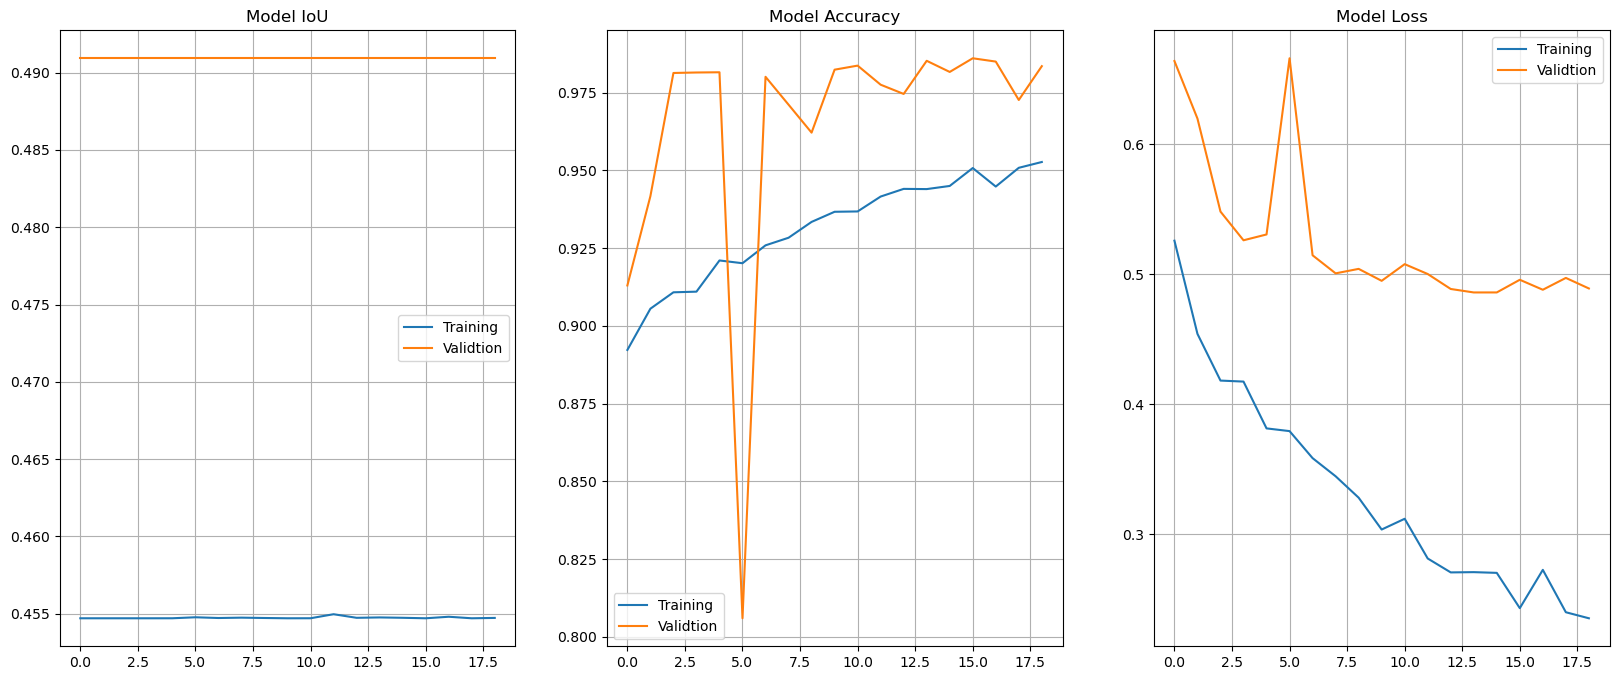

In [28]:
plt.figure(figsize=(20,8))

plt.subplot(1,3,1)
plt.title("Model IoU")
plt.plot(loss, label="Training")
plt.plot(val_loss, label="Validtion")
plt.legend()
plt.grid()

plt.subplot(1,3,2)
plt.title("Model Accuracy")
plt.plot(accuracy, label="Training")
plt.plot(val_accuracy, label="Validtion")
plt.legend()
plt.grid()
plt.subplot(1,3,3)
plt.title("Model Loss")
plt.plot(iou, label="Training")
plt.plot(val_iou, label="Validtion")
plt.legend()
plt.grid()

plt.show()

In [29]:
# Récupération de l'historique d'entraînement
hist = results.history

# Moyennes entraînement
mean_train_acc = sum(hist['accuracy']) / len(hist['accuracy'])
mean_train_iou = sum(hist['IoU']) / len(hist['IoU'])
mean_train_loss = sum(hist['loss']) / len(hist['loss'])

# Moyennes validation
mean_val_acc = sum(hist['val_accuracy']) / len(hist['val_accuracy'])
mean_val_iou = sum(hist['val_IoU']) / len(hist['val_IoU'])
mean_val_loss = sum(hist['val_loss']) / len(hist['val_loss'])

# Affichage du résumé
print(" Moyennes sur toutes les époques")
print(f" Accuracy moyenne (entraînement)     : {mean_train_acc:.4f}")
print(f" Accuracy moyenne (validation)      : {mean_val_acc:.4f}")
print(f" IoU moyenne (entraînement)         : {mean_train_iou:.4f}")
print(f" IoU moyenne (validation)           : {mean_val_iou:.4f}")
print(f" Loss moyenne (entraînement)        : {mean_train_loss:.4f}")
print(f" Loss moyenne (validation)          : {mean_val_loss:.4f}")


 Moyennes sur toutes les époques
 Accuracy moyenne (entraînement)     : 0.9314
 Accuracy moyenne (validation)      : 0.9648
 IoU moyenne (entraînement)         : 0.4547
 IoU moyenne (validation)           : 0.4909
 Loss moyenne (entraînement)        : 0.3318
 Loss moyenne (validation)          : 0.5266


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


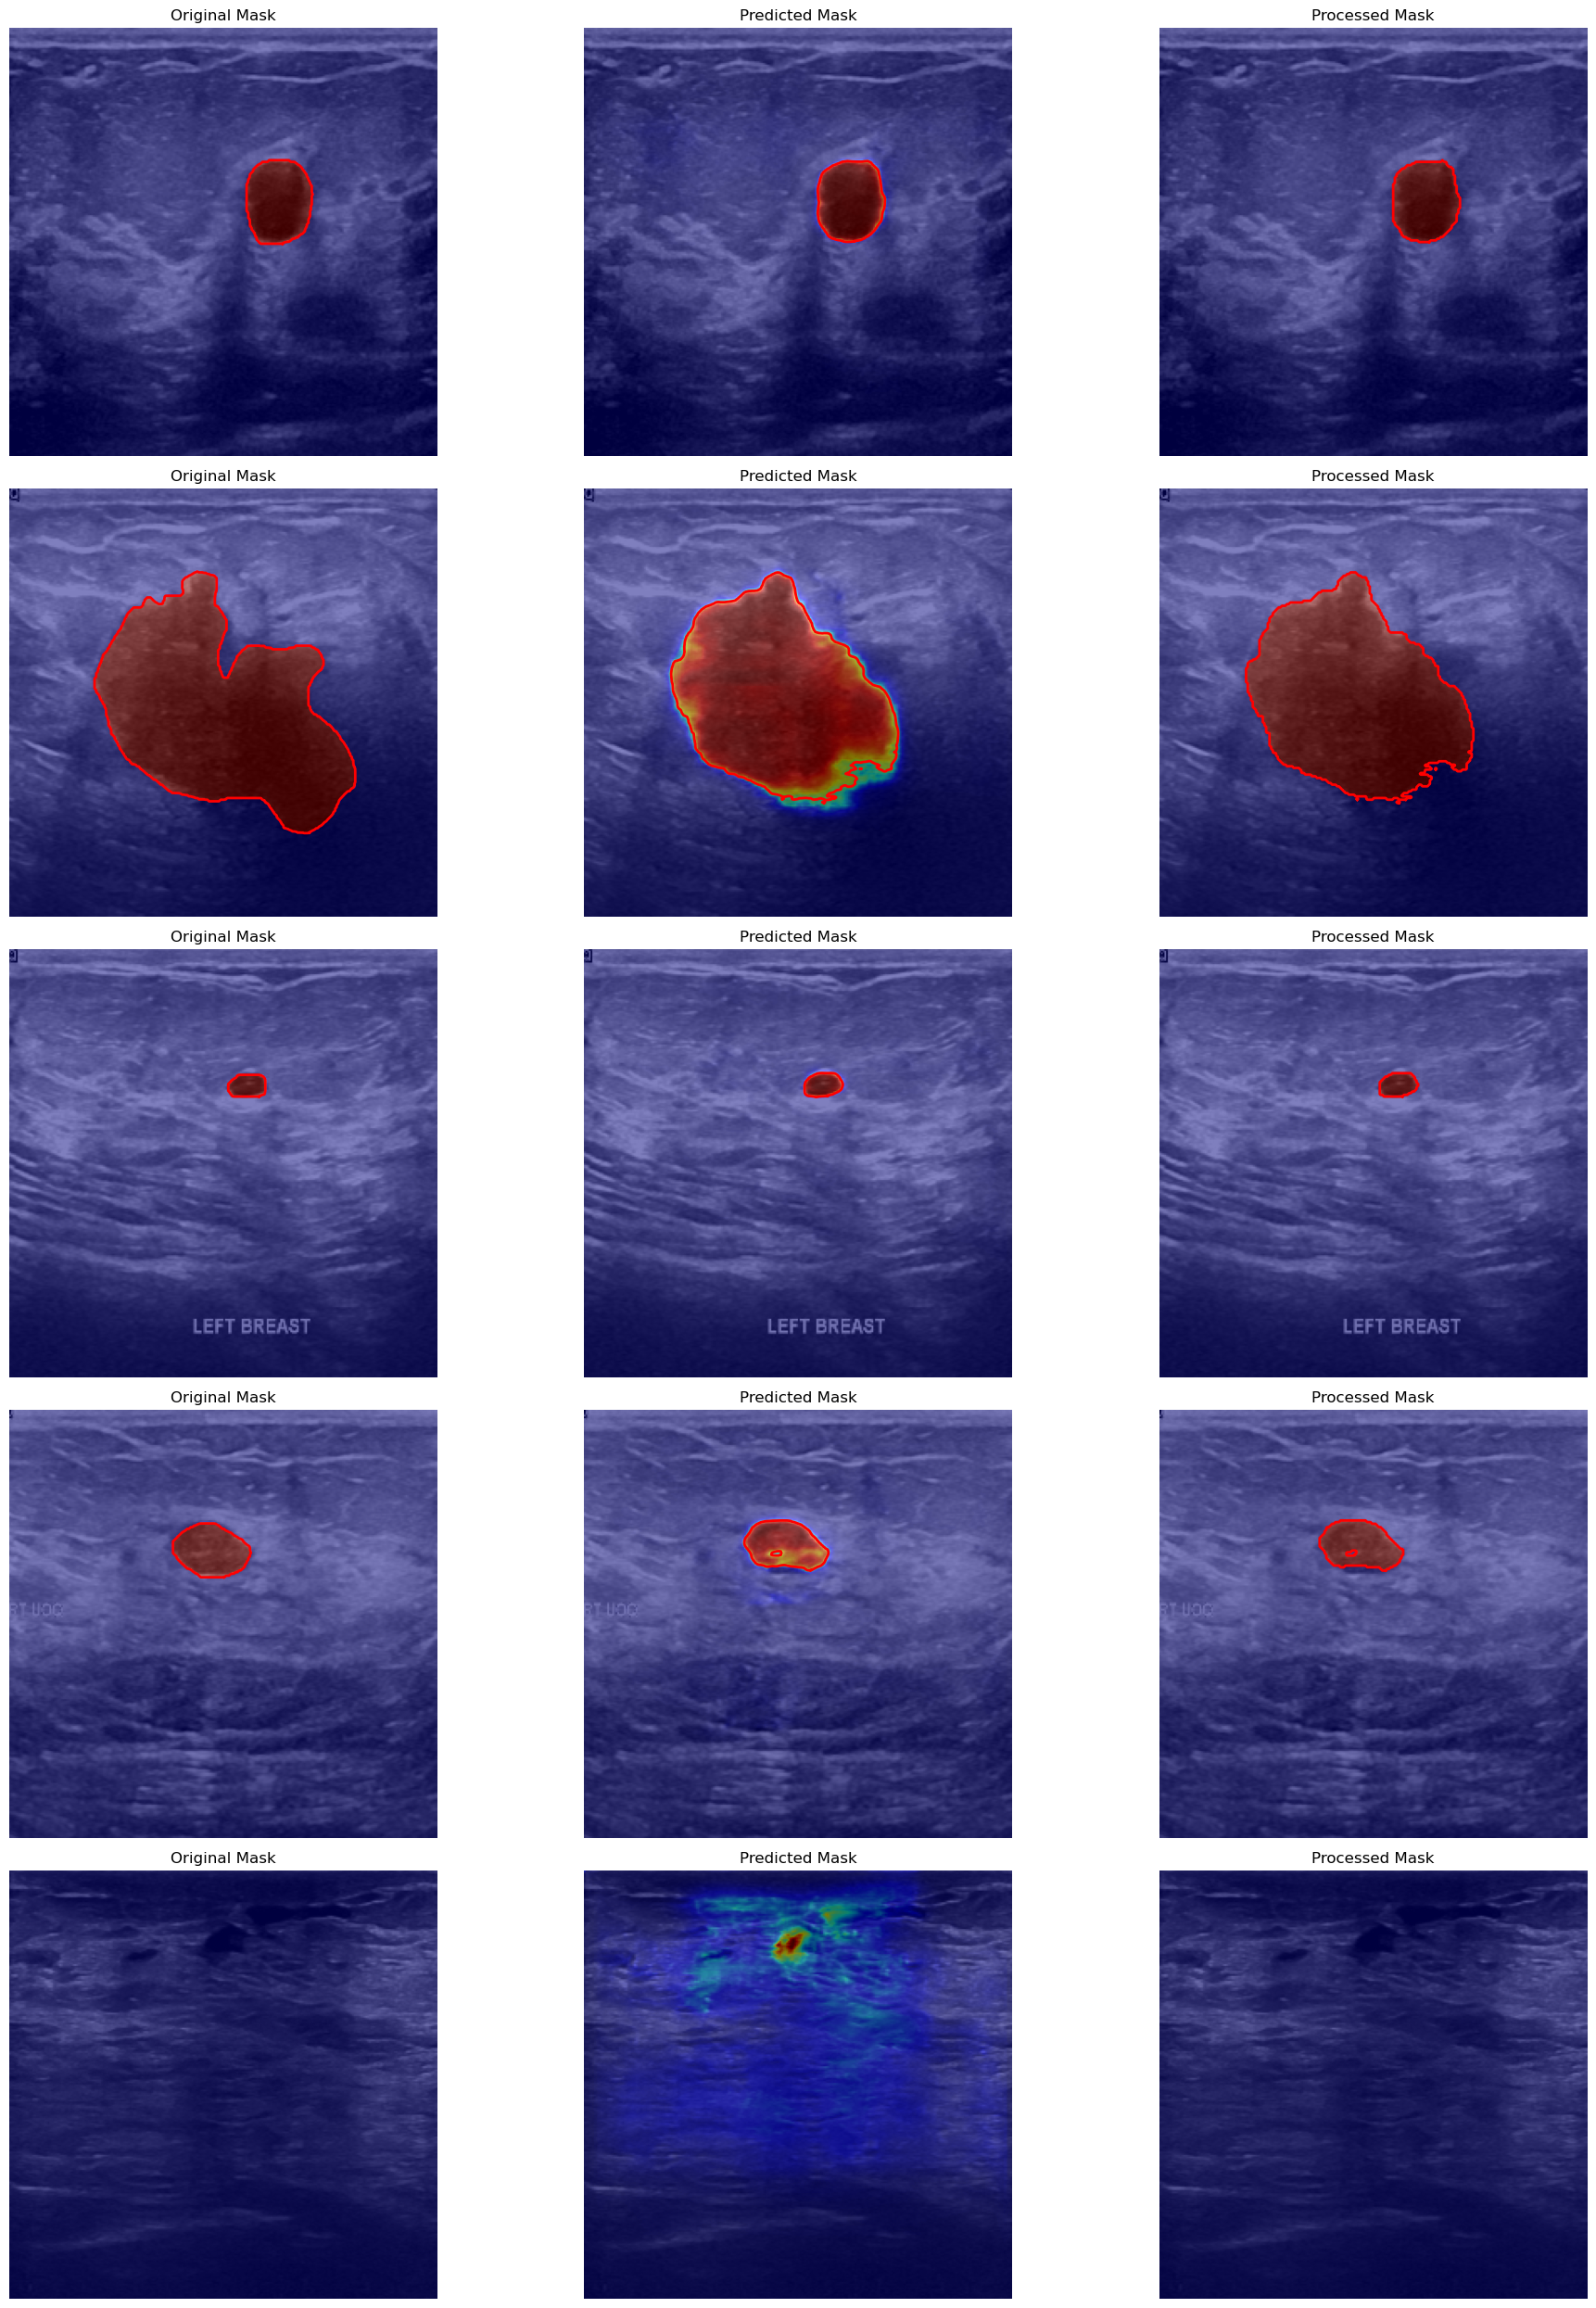

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import find_contours

def show_mask(image, mask, contour_color='red'):
    """Affiche une image avec son masque et entoure le masque en rouge."""
    plt.imshow(image.squeeze(), cmap='gray')  # Affiche l'image en fond
    plt.imshow(mask.squeeze(), cmap='jet', alpha=0.5)  # Superpose le masque avec transparence

    # Trouver les contours du masque
    contours = find_contours(mask.squeeze(), level=0.5)

    # Dessiner les contours en rouge
    for contour in contours:
        plt.plot(contour[:, 1], contour[:, 0], color=contour_color, linewidth=2)

    plt.axis("off")  # Supprimer les axes pour une meilleure visibilité

# Généreration avec contours rouges (choisit par moi même)
plt.figure(figsize=(20, 25))
n = 0

for i in range(1, (5 * 3) + 1):
    plt.subplot(5, 3, i)

    if n == 0:
        id = np.random.randint(len(images))
        image = images[id]
        mask = masks[id]
        pred_mask = model.predict(image[np.newaxis, ...])

        plt.title("Original Mask")   
        show_mask(image, mask)
        n += 1

    elif n == 1:
        plt.title("Predicted Mask")
        show_mask(image, pred_mask[0, ..., 0])  #  Corrigé pour supprimer la dimension en trop
        n += 1

    elif n == 2:
        pred_mask = (pred_mask > 0.5).astype('float')
        plt.title("Processed Mask")
        show_mask(image, pred_mask[0, ..., 0])  #  Corrigé pour supprimer la dimension en trop
        n = 0

plt.tight_layout()
plt.show()           


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Recrée un ImageDataGenerator sans augmentation cette fois (juste normalisation)
predict_datagen = ImageDataGenerator(rescale=1./255)

# Crée un générateur qui ne charge que quelques images à la fois
predict_generator = predict_datagen.flow(
    images,  # Ton tableau d'images
    batch_size=8,
    shuffle=False  # Très important pour garder le bon ordre
)

# Maintenant tu prédis avec le générateur directement
y_pred = model.predict(predict_generator, steps=len(images)//8 + 1)

# Ensuite tu continues comme avant
y_pred_thresholded = (y_pred > 0.5).astype(np.uint8)
y_true_thresholded = (masks > 0.5).astype(np.uint8)

y_true_flat = y_true_thresholded.flatten()
y_pred_flat = y_pred_thresholded.flatten()

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true_flat, y_pred_flat)

print("Matrice de confusion :")
print(cm)